Links from Marisa:

RFE: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE

OHE options: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

### Import the required packages

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.preprocessing import Normalizer, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

### Import the data and create X df for independant variables and y df for dependant variables

In [2]:
data = pd.read_csv('data_cleaned.csv', index_col=0)
data = data.drop(columns=['id', 'long', 'lat', 'date'])
X_cols = data.drop(columns=['price'])
y = data.price.values

### Review histogram from the dependant variables

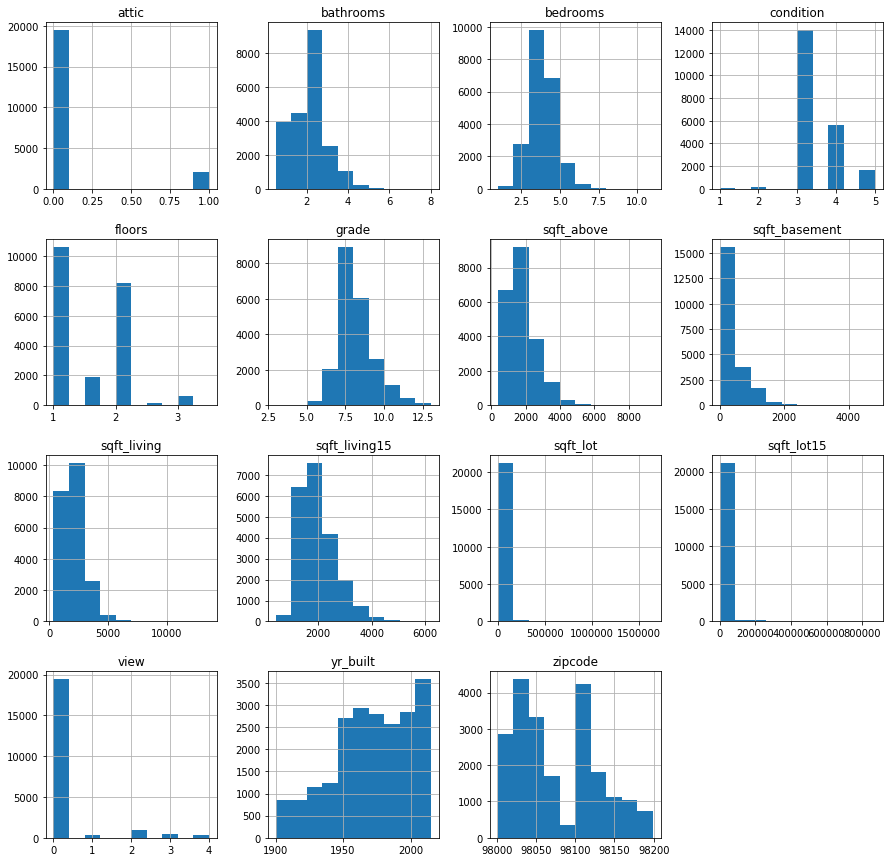

In [3]:
pd.DataFrame.hist(X_cols, figsize = [15,15]);

# residuals of overall model

### Prepare data for the one hot encoding and column transformation
Need to create data frame and lists of categorical variables and continuous variables

In [4]:
categories = X_cols[['bathrooms', 'bedrooms', 'floors', 'condition', 'grade', 'attic', \
                     'zipcode', 'view', 'yr_built']]
categories_ls = list(categories.columns)
x_cols_ls = list(X_cols.columns)
numeric_vars = [x for x in x_cols_ls if x not in categories]

### Create a minimum/maximum value dictionary
This dictionary records the minimum/maximum values for the continuous, independant variables to return to normal values after normalization.  Convert the dicitonary to a dataframe and save as a csv.

In [5]:
# min_max_dict = {}

# for c in X_cols:
#     if c in categories.columns:
#         pass
#     else:
#         min_max_dict.update({c: [X_cols[c].min(), X_cols[c].max()]})

# min_max_df = pd.DataFrame.from_dict(min_max_dict)
# min_max_df.to_csv('min_max_vals')

In [6]:
### Create ohe headers (based on categorical values) and continuous variable headers

### Min/max scaling for independant, continuous variables and convert categorical variables to strings

In [7]:
# Create dictionary of category variable names, counts, and a sorted list of values
category_counts = {}

for cat in categories:
    l = len(list(X_cols[cat].unique())) - 1
    vals = sorted(list(X_cols[cat].unique().round(3)))
    category_counts.update({cat: [l, vals[1:]]})

ohe_cols = []
for cc in category_counts:
    for r in range(0, category_counts[cc][0]):
        column = '{}_{}'.format(cc, category_counts[cc][1][r])
        ohe_cols.append(column)

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()

for c in X_cols.columns:
    if c in categories:
        X_cols[c] = X_cols[c].astype(str)
    else:
        x = np.array(X_cols[c]).reshape(-1, 1)
        X_cols[c] = min_max_scaler.fit_transform(x)

### One hot encoding for housing data

In [9]:
## create an encoder object. This will help us to convert
## categorical variables to new columns
encoder = OneHotEncoder(handle_unknown= 'error',
                        drop='first',
                        categories= 'auto',
                        sparse=True)

## Create an columntransformer object.
## This will help us to merge transformed columns
## with the rest of the dataset.

ct = ColumnTransformer(transformers =[('ohe', encoder, categories_ls)], remainder= 'passthrough')
ct.fit(X_cols[x_cols_ls])
X = ct.transform(X_cols)
X = X.todense()

In [10]:
# Create columns for X df
columns = ohe_cols + numeric_vars

In [11]:
X = pd.DataFrame(X, columns=columns)

### Split data into train and test groups

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Conduct recursive feature elemination

Import RFE packages

In [13]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

#### Attempting friedman1 RFE

In [14]:
# X_train, y_train = make_friedman1(n_samples=50, n_features=5, random_state=0)
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(X, y)
# selector.support_
# selector.ranking_

#### Attemptimg Lasso from sklearn

In [15]:
# Attempt Cross_Validate from sklearn
X = X_train
y = y_train

lasso = linear_model.Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

# want coefficents as the output, documention for LinearModel.Lasso - coeeficent for each feature
# zero coefficients for unimportant features

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
scores = cross_validate(lasso, X, y, cv=4, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

In [23]:
print(scores['test_neg_mean_squared_error'])
print(scores['train_r2'])

[-2.26420083e+10 -3.10492954e+10 -2.38166089e+10 -2.15157572e+10]
[0.82974113 0.84985729 0.83993423 0.83571086]


In [24]:
coefs = {}
for l in range(0, len(lasso.coef_)):
    coefs.update({columns[l]: lasso.coef_[l]})

cdf = pd.DataFrame.from_dict([coefs])
# coefs_df = pd.DataFrame.from_dict(coefs)

In [25]:
pd.set_option('display.max_rows', None)
# cdf.T.sort_values(by=0, ascending=False)
cdf = cdf.T

In [26]:
coef = pd.DataFrame(lasso.coef_, index = X_train.columns)
coef = coef.reset_index()
coef = coef.rename(columns={'index': 'feature', 0: 'coef'})
kill_features = coef.loc[(coef['coef'] == 0)]

In [27]:
kill_features['feature'].values

array(['grade_7'], dtype=object)

In [28]:
def lasso_rfe(X, y, alpha, cv):
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X, y)
    
    scores = cross_validate(lasso, X, y, cv=cv, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
    
    coef = pd.DataFrame(lasso.coef_, index = X_train.columns,)
    coef = coef.reset_index()
    coef = coef.rename(columns={'index': 'feature', 0: 'coef'})
    kill_features = coef.loc[(coef['coef'] == 0)]

    return scores['test_neg_mean_squared_error'], scores['train_r2'], kill_features

In [29]:
# pd.set_option('display.max_columns', None)
# chop_x_train = X_train.drop(columns=['grade_7'])

In [34]:
las = lasso_rfe(X_train, y_train, 100, 4)
print(las[1], len(las[2]))

[0.82289964 0.84143699 0.83206566 0.8297937 ] 77


In [37]:
las[2];

In [36]:
len(las[2])

77

In [ ]:
X_train;

In [ ]:
# def kill_data (drop_cols):
#     categories = X_cols[['bathrooms', 'bedrooms', 'floors', 'condition', 'grade', 'attic', \
#                      'zipcode', 'view', 'yr_built']]
#     categories_ls = list(categories.columns)
#     x_cols_ls = list(X_cols.columns)
#     numeric_vars = [x for x in x_cols_ls if x not in categories]
    
#     category_counts = {}

#     for cat in categories:
#         l = len(list(X_cols[cat].unique())) - 1
#         vals = sorted(list(X_cols[cat].unique().round(3)))
#         category_counts.update({cat: [l, vals[1:]]})

#     ohe_cols = []
#     for cc in category_counts:
#         for r in range(0, category_counts[cc][0]):
#             column = '{}_{}'.format(cc, category_counts[cc][1][r])
#             ohe_cols.append(column)
            
#     min_max_scaler = preprocessing.MinMaxScaler()

#     for c in X_cols.columns:
#         if c in categories:
#             X_cols[c] = X_cols[c].astype(str)
#         else:
#             x = np.array(X_cols[c]).reshape(-1, 1)
#             X_cols[c] = min_max_scaler.fit_transform(x)
            
#     ## create an encoder object. This will help us to convert
#     ## categorical variables to new columns
#     encoder = OneHotEncoder(handle_unknown= 'error',
#                             drop='first',
#                             categories= 'auto',
#                             sparse=True)

#     ## Create an columntransformer object.
#     ## This will help us to merge transformed columns
#     ## with the rest of the dataset.

#     ct = ColumnTransformer(transformers =[('ohe', encoder, categories_ls)], remainder= 'passthrough')
#     ct.fit(X_cols[x_cols_ls])
#     X = ct.transform(X_cols)
#     X = X.todense()
    
#     # Create columns for X df
#     columns = ohe_cols + numeric_vars
    
#     X = pd.DataFrame(X, columns=columns)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Attempt RFE

In [52]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [53]:
model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

KeyboardInterrupt: 

In [ ]:
# # fit a simple logistic regression
# lr = LogisticRegression()
# model = lr.fit(X_train, y_train)

In [ ]:
# y_pred = lr.predict(X_train)



In [ ]:
# lr.score(X_train, y_train)

In [ ]:
# plt.scatter(y_train, y_pred, alpha=0.2, color='navy', )

# plt.xlabel('True Values')
# plt.ylabel('Predictions')

In [ ]:
# grid search cv is another way

In [ ]:
# Attempt Cross_Validate from sklearn
X = X_train
y = y_train

lasso = linear_model.Lasso()

# want coefficents as the output, documention for LinearModel.Lasso - coeeficent for each feature
# zero coefficients for unimportant features

In [ ]:
scores = cross_validate(lasso, X, y, cv=20, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

In [ ]:
print(scores['test_neg_mean_squared_error'])
print(scores['train_r2'])

In [ ]:
# Cross validation with grid search